In [2]:
from data_handling import *
from covariance import *
from sensor_optimisation import *
from visualisation import *

%matplotlib notebook

Data Extraction : 

In [3]:
# Load the Data for given time interval [0 -> 988] 
i_start = 0
i_end = 100
crop_bounds = ((-5,5),(-5,5),(0,20))
field = 'TracerBackground'


In [4]:
loaded_data = load_VTK_data(i_start, i_end, crop_bounds )
data_dict, loc_df, time_vec = loaded_data

Number of Locations :  100040
Number of Locations after croping :  291


Data to Matrix Conversion for the specified Field

In [5]:
d_mat = data_mat(data_dict, field)
d_mat.shape

(291, 101)

In [6]:
crop_data = (field, d_mat, loc_df, time_vec)
save_cropped_data(crop_data, field ,crop_bounds,i_start,i_end)

Saved Data to  ../data/temp_data/TracerBackground_0_100_((-5, 5), (-5, 5), (0, 20))


In [7]:
data_dict, _ , _  = load_VTK_data(0, 1, crop_bounds )
field, d_mat, loc_df, time_vec = load_cropped_data(field ,crop_bounds,i_start,i_end)

Number of Locations :  100040
Number of Locations after croping :  291
Loaded Data from  ../data/temp_data/TracerBackground_0_100_((-5, 5), (-5, 5), (0, 20))


Sample Covariance Matrix

In [8]:
# Sample/Empirical Covariance Matrix
K_sample = sample_cov_matrix(d_mat)
K_sample.shape

(291, 291)

Custom Covariance Matrix 

In [9]:
dist_mat = distance_matrix(loc_df)
lengthscale = 3
K_exp = exponential_kernel(dist_mat,lengthscale)

K_mat32 = matern32_kernel(dist_mat,lengthscale)
K_mat52 = matern52_kernel(dist_mat,lengthscale)


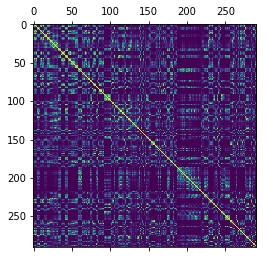

In [10]:
plt.matshow(K_mat52);

We define different sets for all the locations : 
- A : set of sensors selected 
- S : set of potential sensors
- U : set where there is no sensor
- V = S $\cup$ U : set of all positions. 

We want the mutual information to be as high as possible on the set 

In [11]:
n_V = loc_df.shape[0]
sets = define_sets(n_V,n_S = None,seed = 42)
n_V, V, n_S, S, n_U, U = sets

In [12]:
A_naive = approx_max_info(10 , K_mat52, sets)
A_naive

array([239,  10, 114, 275,  44,  38,  31, 143, 121, 167])

In [13]:
A_lazy =  approx_lazy_max_info(10, K_mat52, sets)
A_lazy

array([239,  10, 114, 275,  44,  38,  31, 143, 121, 167])

In [12]:
set(A_lazy) == set(A_naive)

NameError: name 'A_naive' is not defined

<IPython.core.display.Javascript object>


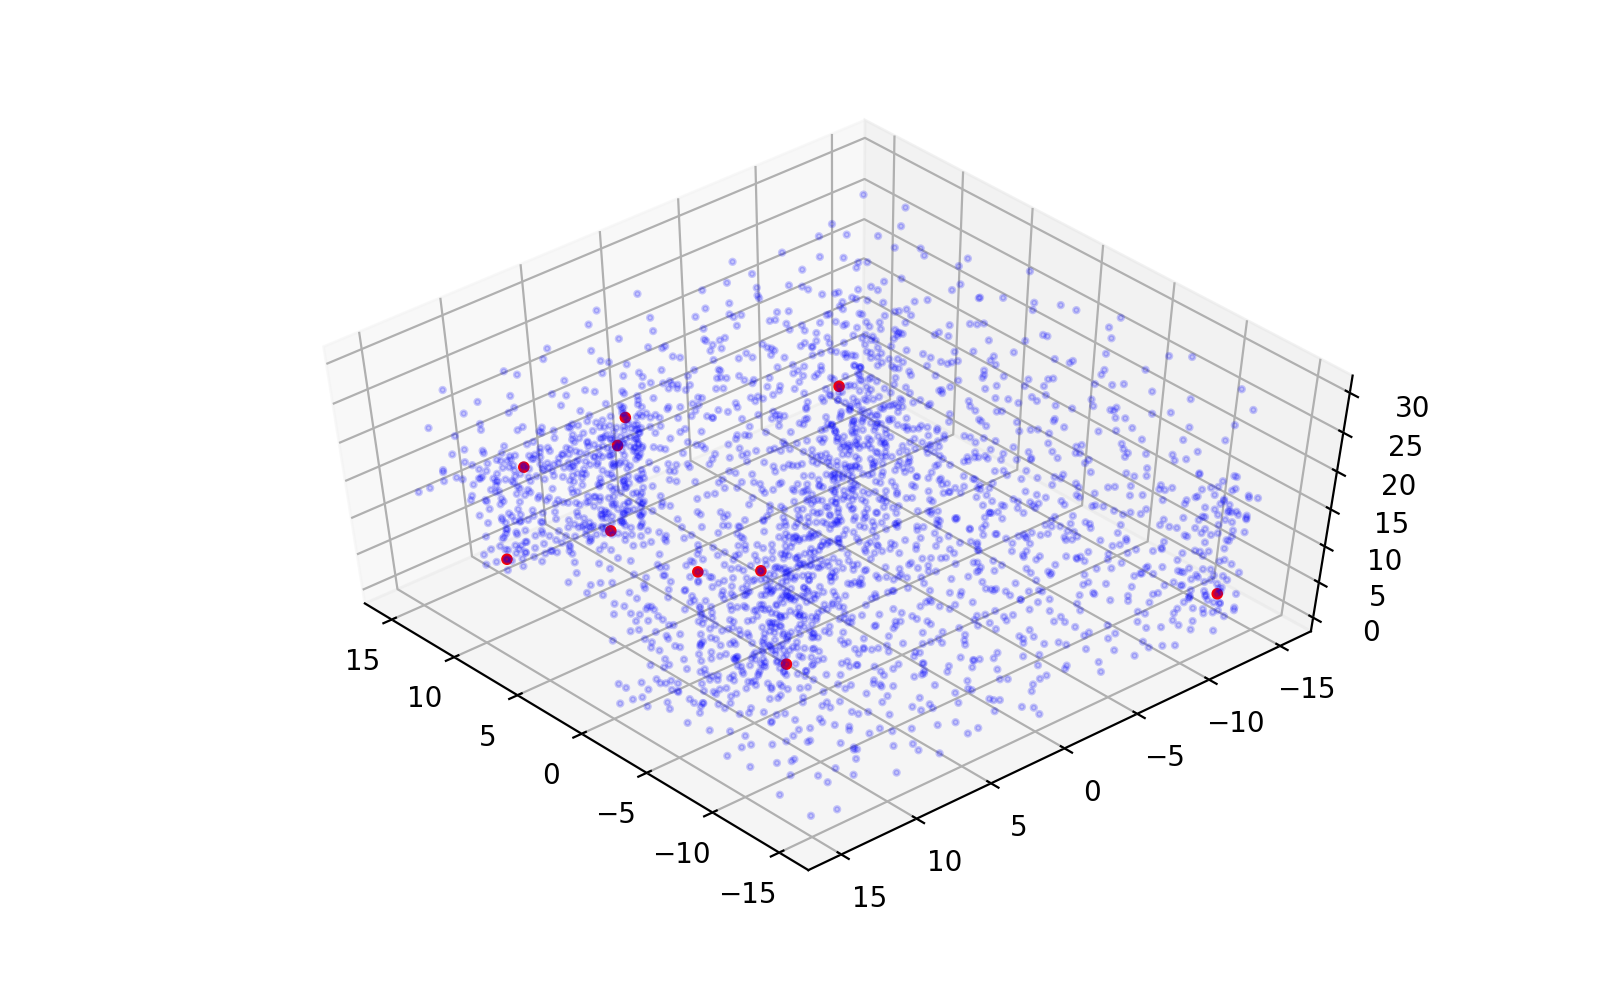

In [19]:
plot_sensors(A_lazy,loc_df)

In [17]:
field_data = np.array([1 if i in set(A_lazy) else 0 for i in S ])
save_VTK_data(data_dict, 'sensors_10', field_data)

../data/temp_data/LSBU_res_2019:06:05-09:21:08_sensors_10.vtu
Saved Data to  ../data/temp_data/LSBU_res_2019:06:05-09:21:08_sensors_10.vtu
